In [5]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../data/raw/train.csv", sep="|")
items = pd.read_csv("../data/raw/items.csv", sep="|")

print(train.shape)
print(items.shape)

(2756003, 11)
(22035, 11)


## 1. Data Integration

In this step, the transactional interaction data (train.csv) is merged with the product metadata (items.csv) using the product identifier (pid).

The goal is to enrich each user interaction with product-level information such as pricing and product attributes.

In [2]:
df = train.merge(items, on="pid", how="left")

print("Train shape:", train.shape)
print("Items shape:", items.shape)
print("Merged shape:", df.shape)

df.head()

Train shape: (2756003, 11)
Items shape: (22035, 11)
Merged shape: (2756003, 21)


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,18,1COJ0FIK,50,ST,TAB,1,40,66.0,C,18.81
2,3,1,16382,0,1,14.77,0,1,0,16.06,...,41,22OI7,2X50,ML,STI,0,53,40.0,NaN,18.48
3,4,1,1145,1,1,6.59,0,0,1,6.55,...,52,18OZ00IS,60,G,GEL,0,40,25.0,NaN,9.31
4,5,1,3394,0,1,4.39,0,0,1,4.14,...,90,20OI0,25X2,ST,KOM,0,53,14.0,NaN,8.13


In [3]:
df[items.columns.difference(["pid"])].isna().all(axis=1).sum()

np.int64(0)

## 2. Missing Value Analysis

Before proceeding with further analysis, it is important to inspect missing values to evaluate data quality and potential preprocessing requirements.

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
missing_percentage = (df.isna().mean() * 100).sort_values(ascending=False)

pd.DataFrame({
    "Missing Count": missing,
    "Missing %": missing_percentage
}).head(20)


,Missing Count,Missing %
campaignIndex,2287968,83.017616
pharmForm,194124,7.043679
competitorPrice,100687,3.653370
category,87394,3.171042
lineID,0,0.000000
availability,0,0.000000
adFlag,0,0.000000
pid,0,0.000000
day,0,0.000000
price,0,0.000000


### Observations on Missing Values

The variable `campaignIndex` contains a high percentage of missing values (83%), which likely indicates that most interactions were not part of a marketing campaign rather than representing data quality issues.

`pharmForm` (7%) and `category` (3%) show moderate but manageable missingness.

`competitorPrice` has 3.65% missing values, which may impact price comparison analysis and will require handling in later preprocessing.

Importantly, core interaction variables (click, basket, order) and price variables do not contain missing values, indicating good data quality for modeling.

## 3. User Interaction Distribution

This section analyzes the distribution of user interactions (click, basket, order) to understand overall engagement and purchasing behavior.

In [7]:
df[["click", "basket", "order"]].mean()

click     0.574320
basket    0.169842
order     0.255838
dtype: float64

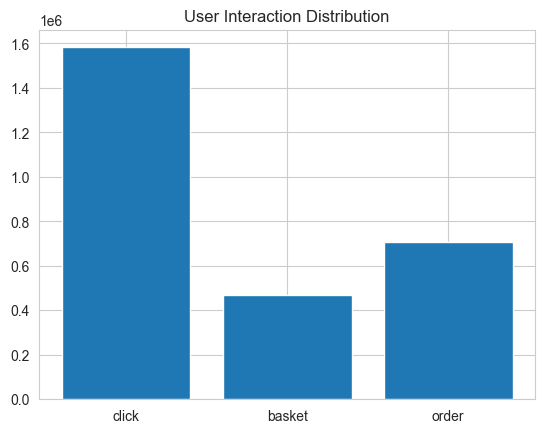

In [6]:
df[["click", "basket", "order"]].sum()
stages = ["click", "basket", "order"]
values = df[stages].sum()

plt.bar(stages, values)
plt.title("User Interaction Distribution")
plt.show()

### Observations on User Interaction

The click rate is approximately 57%, indicating that more than half of the interactions involve product clicks.

The basket rate is around 17%, suggesting that a smaller portion of interactions lead to cart additions.

Interestingly, the order rate (26%) is higher than the basket rate. This indicates that the interaction variables do not represent a strict sequential funnel. Instead, they appear to capture independent user actions.

Overall, the order rate of 25.6% reflects a relatively strong conversion level within the dataset.

## 4. Price Analysis

This section examines the distribution of product prices and competitor prices.
Understanding pricing structure and variability is essential for evaluating pricing strategy and potential competitive positioning.

In [8]:
df[["price", "competitorPrice"]].describe()


,price,competitorPrice
count,2.756003e+06,2.655316e+06
mean,1.385008e+01,1.277288e+01
std,1.362307e+01,1.275295e+01
min,2.000000e-02,0.000000e+00
25%,6.000000e+00,5.480000e+00
50%,9.850000e+00,8.990000e+00
75%,1.645000e+01,1.506000e+01
max,3.788400e+02,2.645900e+02


### Observations on Price Distribution

The average product price is 13.85, while the median price is 9.85, indicating a right-skewed distribution where a small number of high-priced products increase the mean.

Most products are priced below 16.45 (75th percentile), suggesting that the majority of items fall within a relatively moderate price range.

Competitor prices show a similar distribution pattern, with a slightly lower mean value (12.77) and median (8.99). This suggests that competitors may price products marginally lower on average.

The presence of extreme maximum values (up to 378.84) indicates potential outliers that could influence modeling results and may require transformation or normalization during preprocessing.

In [9]:
df["price_diff"] = df["price"] - df["competitorPrice"]

df["price_diff"].describe()

count    2.655316e+06
mean     8.650459e-01
std      3.949754e+00
min     -1.423900e+02
25%     -4.000000e-02
50%      7.300000e-01
75%      1.850000e+00
max      1.368700e+02
Name: price_diff, dtype: float64

### Observations on Competitive Pricing

The average price difference is +0.87, indicating that the company’s products are priced slightly higher than competitors on average.

The median difference of +0.73 confirms this tendency, suggesting that more than half of the products are priced above competitor levels.

However, the distribution shows variability: 25% of products are priced slightly below competitors (price_diff < 0), while 75% are priced up to 1.85 higher.

The presence of extreme minimum and maximum values (-142.39 to +136.87) suggests significant outliers, which may represent special product categories or pricing inconsistencies. These extreme values may require further investigation or transformation during preprocessing.